# Motor Identification

In [6]:
import sys
sys.path.append('..')

In [7]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [8]:
from ctrl.algo import Proportional, PID, VelocityController, OpenLoop

In [9]:
from ctrl.client import Controller
HOST, PORT = "192.168.10.102", 9999
controller = Controller(HOST, PORT)

##Static Curve

In [77]:
controller.set_controller1(OpenLoop())
controller.reset_logger()
dT = 5
controller.set_encoder1(0)
with controller:
    time.sleep(1)
    for duty_cycle in range(0,100,5):
        print('\rduty cycle = {}%'.format(100-duty_cycle), end='')
        controller.set_reference1(100-duty_cycle)
        time.sleep(dT)
log = controller.get_log()

duty cycle = 5%

In [78]:
t = log[:,0]
position = log[:,1]
reference = log[:,2]
velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

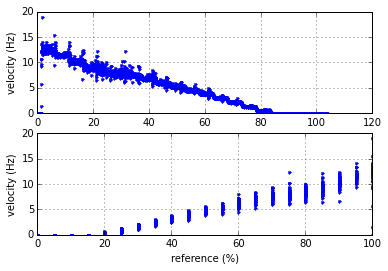

In [79]:
plt.subplot(2,1,1)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(reference, velocity, '.')
plt.xlabel('reference (%)')
plt.ylabel('velocity (Hz)')
plt.grid()

In [80]:
def func(x, a, v0):
    return a * (x - v0)

import scipy.optimize as optimize

ind = np.where(velocity > 0)
pars, residues = optimize.curve_fit(func, reference[ind], velocity[ind])
a, v0 = pars.tolist()
print('a = {:4.3f}, v0 = {:4.3f}'.format(a,v0))

a = 0.148, v0 = 19.868


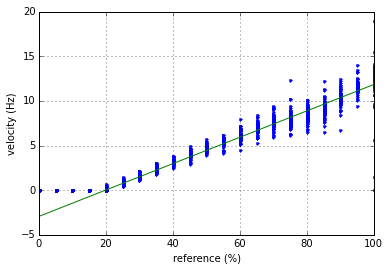

In [81]:
plt.plot(reference, velocity, '.', np.array([0,100]), a * (np.array([0,100]) - v0),'-')
plt.xlabel('reference (%)')
plt.ylabel('velocity (Hz)')
plt.grid()

##Dynamic Response

With a constant input:
$$
\omega(t) = \bar{\omega} \left ( 1 - e^{\lambda t} \right )
$$
where:
$$
\begin{aligned}
\bar{\omega} &= a \, (v_a - v_0), & a &= \frac{k_m}{b_m}, & \lambda &= \frac{b_m}{J_m}
\end{aligned}
$$

In [82]:
controller.set_controller1(OpenLoop())
controller.reset_logger()
controller.set_encoder1(0)
with controller:
    controller.set_reference1(90)
    time.sleep(3)
    controller.set_reference1(0)
    time.sleep(1)
    controller.set_reference1(90)
    time.sleep(3)
    controller.set_reference1(0)
    time.sleep(1)
log = controller.get_log()

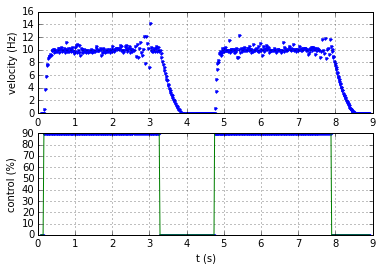

In [83]:
t = log[:,0]
position = log[:,1]
reference = log[:,2]
control = log[:,3]
velocity = np.zeros(t.shape, float)
velocity[1:] = (position[1:]-position[:-1])/(t[1:]-t[:-1])

plt.subplot(2,1,1)
plt.plot(t, velocity, '.')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, control, '.', t, reference, '-')
plt.xlabel('t (s)')
plt.ylabel('control (%)')
plt.grid()

In [74]:
ind = np.where((t > 1) & (t < 3))
vmean = np.mean(velocity[ind])
vstd = np.std(velocity[ind])
print('mean = {:5.3f}, omegabar = {:5.3f}, standard deviation = {:5.3f}'.format(vmean,a * (90-v0),vstd))

mean = 9.899, omegabar = 10.010, standard deviation = 0.608


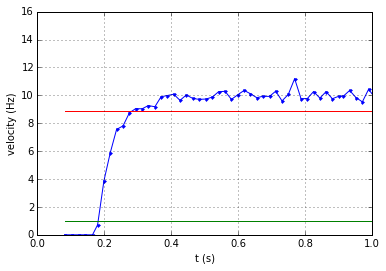

In [84]:
plt.plot(t, velocity, '.-', 
         np.array([t[0],t[-1]]), np.array(2*[0.1*vmean]), '-',
         np.array([t[0],t[-1]]), np.array(2*[0.9*vmean]), '-')
plt.xlim(0,1)
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

In [85]:
tr = t[np.where(velocity >= 0.9*vmean)][1] - t[np.where(velocity >= 0.1*vmean)][0] 
tau = tr / 2.2
lamb = 1/tau
print('tr = {:5.3f}, tau = {:5.3f}, lambda = {:5.3f}'.format(tr, tau, lamb))

tr = 0.114, tau = 0.052, lambda = 19.312


## Identifying $J_m$

Repeat experiment with known $J_a$ then:
$$
(J_m + J_a) \, \dot{\omega} + b_m \, \omega = k_m \, (v_a - v_0)
$$
then:
$$
\begin{aligned}
a &= \frac{k_m}{b_m}, & \lambda_a &= \frac{b_m}{J_m + J_a} = \frac{1}{1 + J_a/J_m} \frac{b_m}{J_m} = \rho^{-1} \lambda, & \rho &= \frac{\lambda}{\lambda_a} = 1 + J_a/J_m
\end{aligned}
$$
From here:
\begin{aligned}
J_m &= \frac{J_a}{\rho - 1}, &
b_m &= \lambda \, J_m, &
k_m &= a \, b_m.
\end{aligned}



In [90]:
lamba = 12.9
ma = 60/1000
ra = 3.8/100
Ja = ma*ra**2/2
print('Ja = {:8.6f}'.format(Ja))

Ja = 0.000043


In [94]:
rho = lamb/lamba
Jm = Ja/(rho-1)
bm = lamb * Jm
km = a * bm
print('Jm = {:8.6f}, km = {:8.6f}, bm = {:8.6f}'.format(Jm,km,bm))

Jm = 0.000087, km = 0.000249, bm = 0.001683
